In [1]:
import sys
sys.path.append('../src')

import requests

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

# CSV file contains city names, their BLS codes (Metropolitan 
# MTAs/NECTAs only), and their latitude and longitude
MSA = pd.read_csv('shapefiles/MSA.csv')

# BLS flat file contains the unemployment rate by month since 2015
url = 'https://download.bls.gov/pub/time.series/la/la.data.60.Metro'
df = pd.read_table(url, sep='\s+', dtype='object')

In [2]:
# Import libraries and adjust settings
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
plt.rc('font', family='Lato')

In [3]:
date = lambda x: x['year'].astype('str') + '-' + x['period'].str[1:] + '-01'

data = (df[df['series_id'].isin(MSA['fullcode']) & ~df['period'].isin(['M13'])]
          .assign(DATE = date)
          .set_index(['series_id','DATE'])
          .value).unstack().T.dropna().astype('float').diff(12).iloc[-1]

datelt = pd.to_datetime(data.name)
text = datelt.strftime('%B %Y')
write_txt(text_dir / 'unemp_map_date.txt', text)
print(text)

data = data.rename('value')

ms = MSA.set_index('fullcode').join(data)
ms['color'] = np.where(ms.value > 0, 'greenyellow', np.where(ms.value < 0, 'lightblue', 'gray'))
ms['size'] = np.where(abs(ms.value) > 0, (abs(ms.value)), 1)

May 2020


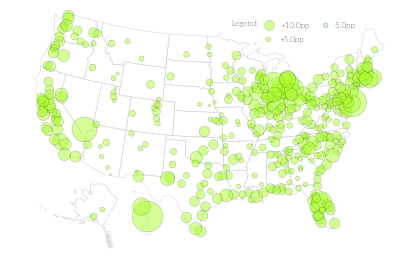

In [4]:
# Draw map
# Map and legend settings
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

fig = plt.figure(figsize=(9.0,4.5))

m.readshapefile('shapefiles/states', 'st', drawbounds=True, color='lightgrey')

ax = plt.gca()

   
for info, shape in zip(m.st_info, m.st):
    if info['STATE_NAME'] == 'Hawaii':
        shape2 = [[x + 5200000, y - 1400000] for x, y in shape]
        ax.add_patch(Polygon(shape2, fc='white', ec='lightgray', lw=0.5)) 
    elif info['STATE_NAME'] == 'Alaska':
        shape2 = [(x * 0.34 + 1200000, 
                  y * 0.34 - 1300000) for x, y in shape]
        ax.add_patch(Polygon(shape2, fc='white', ec='lightgray', lw=0.5))    
        
# Plot each location, value, and color as identified in the previous section        
for index, row in ms.iterrows():
    x, y = m(row['longitude'], row['latitude'])
    if row['fullname'].endswith('HI'):
        x = x + 5200000
        y = y - 1400000
    if row['fullname'].endswith('AK'):
        x = x * 0.34 + 1200000
        y = y * 0.34 - 1300000
    m.plot(x, y, marker='o', color=row['color'], alpha=0.5, markersize=row['size'], 
           markeredgecolor='black', markeredgewidth=.25)

x, y = m(-86.4, 48.4)
m.plot(x, y, marker='o', color='greenyellow', alpha=0.5, markersize=5, 
       markeredgecolor='black', markeredgewidth=.25)   
x, y = m(-84.4, 47.9)
plt.annotate('+5.0pp', xy=(x, y),  xycoords='data', fontsize=8)

x, y = m(-86, 50.0)
m.plot(x, y, marker='o', color='greenyellow', alpha=0.5, markersize=10, 
       markeredgecolor='black', markeredgewidth=.25) 
x, y = m(-84, 49.5)
plt.annotate('+10.0pp', xy=(x, y),  xycoords='data', fontsize=8)

x, y = m(-76, 49.0)
m.plot(x, y, marker='o', color='lightblue', alpha=0.5, markersize=5, 
       markeredgecolor='black', markeredgewidth=.25) 
x, y = m(-74.8, 48.5)
plt.annotate('-5.0pp', xy=(x, y),  xycoords='data', fontsize=8)

x, y = m(-93, 50.2)
plt.annotate('Legend:', xy=(x, y),  xycoords='data', fontsize=8)

ax.axis('off')

plt.savefig(data_dir / 'unemp_msa.pgf', bbox_inches='tight')